In [ ]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
#import keras.models 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization, Add, Multiply, Input, Reshape
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, Lambda, Concatenate
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import regularizers, optimizers
from keras.datasets import cifar10
from tensorflow.keras import regularizers
from keras.models import Model
import tensorflow as tf

import cv2
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from IPython.display import Image, display

In [ ]:
#Algortimo de GradCAM para visualizacion
#Author: fchollet
#Libro: Deep Learning with Python (2017)
#Description: How to obtain a class activation heatmap for an image classification model.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/Modelos/mod_basPRO64.hdf5 /content/
!cp /content/gdrive/MyDrive/Modelos/mod_sqxM.hdf5 /content/
!cp /content/gdrive/MyDrive/Modelos/M.hdf5 /content/

!ls

gdrive	M.hdf5	mod_basPRO64.hdf5  mod_sqxM.hdf5  sample_data


In [ ]:
etiquetas = np.array([
                      
     'airplane',
     'automobile',
     'bird',
     'cat',
     'deer',
     'dog',
     'frog',
     'horse',
     'ship',
     'truck'

])

In [ ]:
from keras.models import load_model

modelResnet =tf.keras.models.load_model('/content/mod_basPRO64.hdf5')
modelsqx = tf.keras.models.load_model('/content/mod_sqxM.hdf5')
modelcbam = tf.keras.models.load_model('/content/M.hdf5')

In [ ]:
modelResnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 3)   84          ['input_1[0][0]']                
 ose)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 3)   12          ['conv2d_transpose[0][0]']       
 alization)                                                                                       
                                                                                              

In [ ]:
modelsqx.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 3)   84          ['input_1[0][0]']                
 ose)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 3)   12          ['conv2d_transpose[0][0]']       
 alization)                                                                                       
                                                                                              

In [ ]:
modelcbam.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 3)   84          ['input_1[0][0]']                
 ose)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 3)   12          ['conv2d_transpose[0][0]']       
 alization)                                                                                       
                                                                                              

In [ ]:
import cv2
preprocess_input = keras.applications.xception.preprocess_input

img= cv2.imread('dog1.jpg')
size= (img.shape[0],img.shape[1])
img_show =cv2.resize(img, size)

img_array = cv2.resize(img,(32,32))
img_array = img_array.astype('float32')/255.0
img_array = np.expand_dims(img_array,axis=0)


##img_array = preprocess_input(get_img_array('a1.jpg', size=(32,32)))
##img_array = img_array.astype('float32')/255.0
##mean = np.mean(img_array,axis=(0,1,2,3))
##std = np.std(img_array,axis=(0,1,2,3))
##img_array=(img_array-mean)/(std+1e-7)
preds1 = modelResnet.predict(img_array)
preds2 = modelsqx.predict(img_array)
preds3 = modelcbam.predict(img_array)


label1= str(etiquetas[(np.argmax(preds1,axis=1))])
print("prediccion resnet",str(etiquetas[(np.argmax(preds1,axis=1))]))
print("prediccion resnet y sqx",str(etiquetas[(np.argmax(preds2,axis=1))]))
print("prediccion resnet y cbam",str(etiquetas[(np.argmax(preds3,axis=1))]))


heatmap1 = make_gradcam_heatmap(img_array, modelResnet, 'activation_48')
heatmap2 = make_gradcam_heatmap(img_array, modelsqx, 'activation_48')
heatmap3 = make_gradcam_heatmap(img_array, modelcbam, 'activation_60')


prediccion resnet ['cat']
prediccion resnet y sqx ['dog']
prediccion resnet y cbam ['dog']


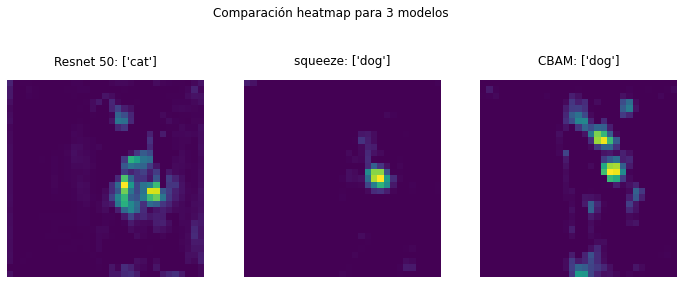

In [ ]:
fig=plt.figure(figsize=(12,5))
subplot=fig.add_subplot(1,3,1)
subplot.matshow(heatmap1)
plt.title("Resnet 50: "+str(etiquetas[(np.argmax(preds1,axis=1))]))
plt.axis('off')

subplot=fig.add_subplot(1,3,2)
subplot.matshow(heatmap2)
plt.title("squeeze: "+str(etiquetas[(np.argmax(preds2,axis=1))]))
plt.axis('off')

subplot=fig.add_subplot(1,3,3)
subplot.matshow(heatmap3)
plt.title("CBAM: "+str(etiquetas[(np.argmax(preds3,axis=1))]))
plt.axis('off')

fig.suptitle("Comparación heatmap para 3 modelos")
plt.show()


In [ ]:
import matplotlib.cm as cm

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

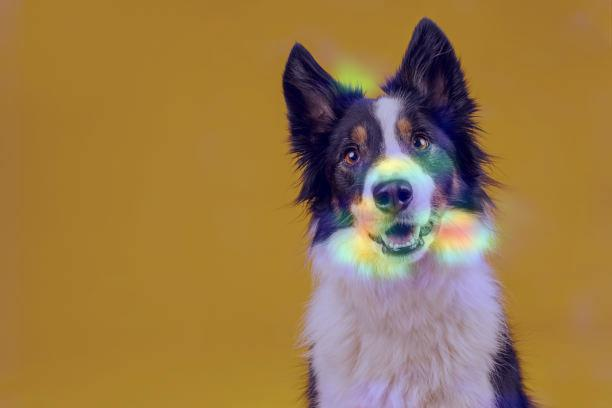

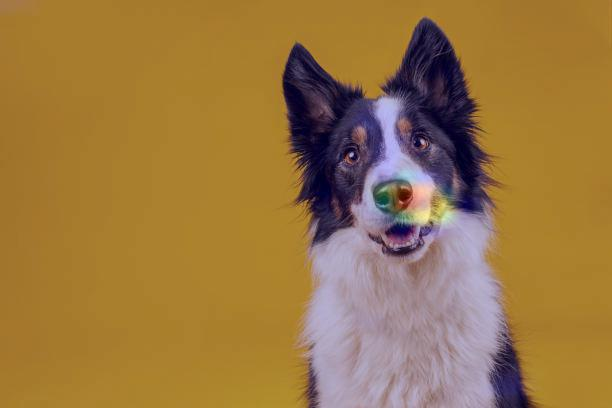

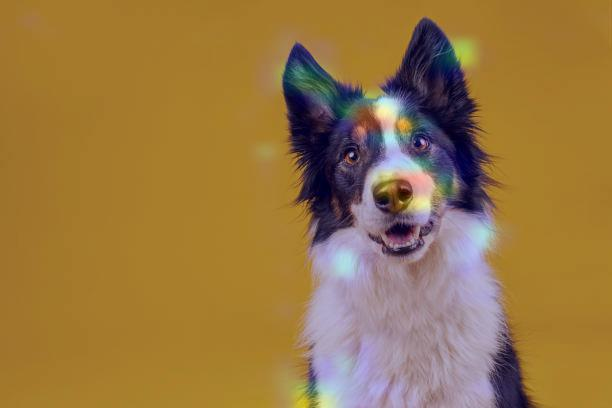

In [ ]:
save_and_display_gradcam('dog1.jpg',heatmap1, 'a.jpg')
save_and_display_gradcam('dog1.jpg',heatmap2, 'b.jpg')
save_and_display_gradcam('dog1.jpg',heatmap3, 'c.jpg')

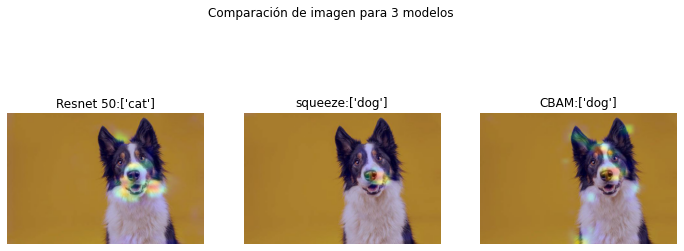

In [ ]:
import matplotlib.image as img
img1=img.imread("/content/a.jpg")
img2=img.imread("/content/b.jpg")
img3=img.imread("/content/c.jpg")


fig=plt.figure(figsize=(12,5))
subplot=fig.add_subplot(1,3,1)
subplot.imshow(img1)
plt.title("Resnet 50:"+str(etiquetas[(np.argmax(preds1,axis=1))]))
plt.axis('off')

subplot=fig.add_subplot(1,3,2)
subplot.imshow(img2)
plt.title("squeeze:"+str(etiquetas[(np.argmax(preds2,axis=1))]))
plt.axis('off')

subplot=fig.add_subplot(1,3,3)
subplot.imshow(img3)
plt.title("CBAM:"+str(etiquetas[(np.argmax(preds3,axis=1))]))
plt.axis('off')

fig.suptitle("Comparación de imagen para 3 modelos")
plt.show()
